# Activaciones e inicializaciones


En este curso, retomaremos el modelo **Fully Connected** presentado en el curso 5 sobre **PNL (Procesamiento del Lenguaje Natural)**. Analizaremos el comportamiento de las **activaciones** a lo largo de la red durante su inicialización. Este contenido está inspirado en la clase de Andrej Karpathy titulada [*Building makemore Part 3: Activations & Gradients, BatchNorm*](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=3892s&ab_channel=AndrejKarpathy).


Las redes neuronales ofrecen varias ventajas:
- Son muy **flexibles** y pueden resolver una amplia variedad de problemas.
- Su implementación es relativamente **sencilla**.

Sin embargo, su **optimización** suele ser compleja, especialmente cuando se trata de redes **profundas**.


## Recuperación de código

Estamos usando el código del [cuaderno 3 del curso 5 sobre PNL](../05_NLP/03_RéseauFullyConnected.ipynb).


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../05_NLP/prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Por razones pedagógicas, **no utilizaremos** el *dataset* ni el *dataloader* de PyTorch. En su lugar, evaluaremos la **pérdida (*loss*)** al inicio del entrenamiento, tras procesar el primer *batch*. El procedimiento es similar al estándar, con una diferencia clave: en cada iteración, seleccionamos un *batch* **aleatorio** en lugar de recorrer todo el *dataset* en cada *epoch*.


In [3]:
block_size = 3 # Contexte

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([180834, 3]) torch.Size([180834])
torch.Size([22852, 3]) torch.Size([22852])
torch.Size([22639, 3]) torch.Size([22639])


In [4]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [5]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # Permet de construire un mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # Forward
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 

  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  # Retropropagation
  for p in parameters:
    p.grad = None
  
  loss.backward()
  # Mise à jour des paramètres
  lr = 0.1 if i < 100000 else 0.01 # On descend le learning rate d'un facteur 10 après 100000 itérations
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 21.9772
  10000/ 200000: 2.9991
  20000/ 200000: 2.5258
  30000/ 200000: 1.9657
  40000/ 200000: 2.4326
  50000/ 200000: 1.7670
  60000/ 200000: 2.1324
  70000/ 200000: 2.4160
  80000/ 200000: 2.2237
  90000/ 200000: 2.3905
 100000/ 200000: 1.9304
 110000/ 200000: 2.1710
 120000/ 200000: 2.3444
 130000/ 200000: 2.0970
 140000/ 200000: 1.8623
 150000/ 200000: 1.9792
 160000/ 200000: 2.4602
 170000/ 200000: 2.0968
 180000/ 200000: 2.0466
 190000/ 200000: 2.3746


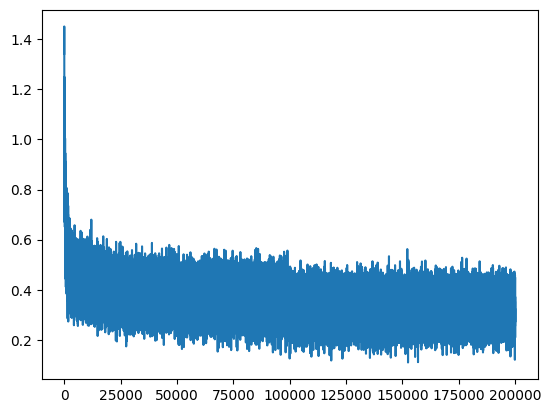

In [6]:
plt.plot(lossi)

Hay mucho **"ruido"** en los resultados, ya que calculamos la **pérdida (*loss*)** en *batches* pequeños en comparación con el conjunto completo de datos de entrenamiento.


## Pérdida anormalmente alta en la inicialización

El entrenamiento transcurre correctamente. No obstante, observamos algo **anómalo**: la **pérdida inicial (*loss*)** es **excesivamente alta**. Lo esperado sería un valor equivalente a un escenario donde cada letra tenga una **probabilidad uniforme** de aparición (es decir, $p = \frac{1}{46}$).

En este caso, el *negative log likelihood* sería:
$-ln\left(\frac{1}{46}\right) = 3.83$

Por lo tanto, sería lógico obtener un valor cercano a este en el primer cálculo de *loss*.


### Pequeño ejemplo que ilustra el problema


Para entender qué está ocurriendo, utilicemos un **ejemplo sencillo** y analicemos los valores de *loss* según la inicialización. Supongamos que **todos los pesos** en *logits* se inicializan en **0**. En este caso, obtendríamos probabilidades **uniformes**.


In [7]:
logits=torch.tensor([0.0,0.0,0.0,0.0])
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

Sin embargo, **no es recomendable** inicializar los pesos de una red neuronal en **0**. En su lugar, hemos utilizado una **inicialización aleatoria** basada en una distribución **gaussiana estándar** (media = 0, desviación estándar = 1).


In [8]:
logits=torch.randn(4)
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.3143, 0.0607, 0.3071, 0.3178]), tensor(2.8012))

El problema es evidente: el **azar de la distribución gaussiana** desequilibra los valores hacia un extremo u otro (puedes ejecutar el código anterior varias veces para verificarlo).

**¿Cómo solucionarlo?**
Basta con multiplicar nuestro vector *logit* por un **valor pequeño** (ej. 0.01) para reducir la magnitud inicial de los pesos y lograr que la salida de *softmax* sea más **uniforme**.


In [9]:
logits=torch.randn(4)*0.01
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2489, 0.2523, 0.2495, 0.2493]), tensor(1.3772))

Obtenemos un valor de *loss* **muy cercano** al esperado para probabilidades uniformes.

**Nota**:
En cambio, **sí es válido** inicializar los **sesgos (*bias*)** en **0**, ya que no tiene sentido asignarles un valor positivo o negativo al inicio.


### Entrenamiento con ajuste de inicialización


Retomemos el código anterior, pero **aplicando los nuevos valores de inicialización**.


In [10]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))*0.01 # On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46))*0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [11]:
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 
  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.8304
  10000/ 200000: 2.4283
  20000/ 200000: 2.0651
  30000/ 200000: 2.1124
  40000/ 200000: 2.3158
  50000/ 200000: 2.2752
  60000/ 200000: 2.1887
  70000/ 200000: 2.1783
  80000/ 200000: 1.8120
  90000/ 200000: 2.3178
 100000/ 200000: 2.0973
 110000/ 200000: 1.8992
 120000/ 200000: 1.6917
 130000/ 200000: 2.2747
 140000/ 200000: 1.8054
 150000/ 200000: 2.3569
 160000/ 200000: 2.4231
 170000/ 200000: 2.0711
 180000/ 200000: 2.1379
 190000/ 200000: 1.8419


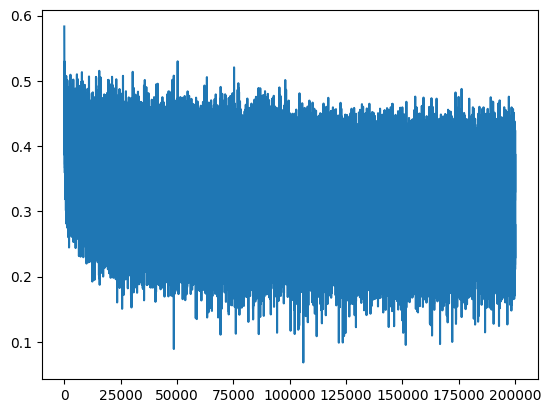

In [12]:
plt.plot(lossi)

Ahora obtenemos una **curva de pérdida (*loss*)** que **no parte de un valor anómalo**, lo que **acelera significativamente** el proceso de optimización.


## Otro problema


Podría pensarse que un *loss* elevado no es necesariamente un problema. Sin embargo, una **mala inicialización de los pesos** puede generar **otros inconvenientes**.

Analicemos la **primera iteración** del entrenamiento con valores inicializados **sin el factor 0.01**.


In [13]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) 
b1 = torch.randn(hidden_dim) 
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [14]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

Observamos el histograma de valores después de la función de activación *tanh*.

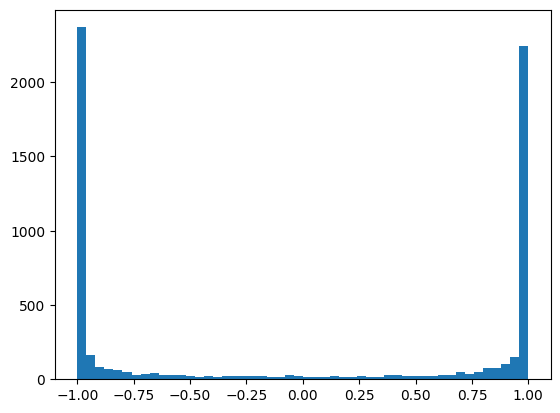

In [15]:
plt.hist(h.view(-1).tolist(),50);

Observamos que la **mayoría de los valores** se concentran alrededor de **1 o -1**.

**¿Por qué es esto un problema?**
Durante el cálculo del gradiente, al aplicar la **regla de la cadena**, multiplicamos los gradientes de las distintas etapas. La derivada de la función *tanh* es:
$tanh'(t) = 1 - t^2$

Si los valores de $t$ están cerca de **1 o -1**, el gradiente será **extremadamente pequeño** (nunca cero, pues es una asíntota). Esto implica que **el gradiente no se propaga** correctamente, dificultando la optimización al inicio del entrenamiento.


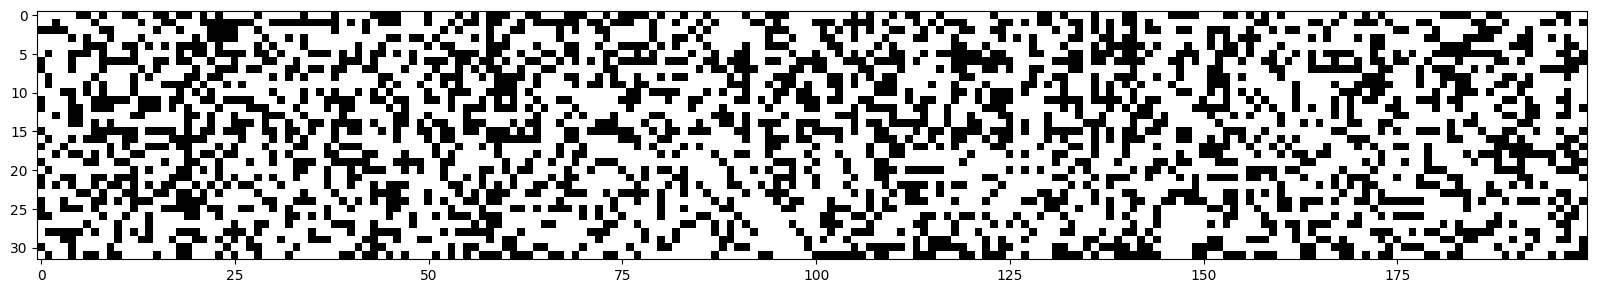

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

Cada **punto blanco** representa un neurona cuyo gradiente es **aproximadamente 0**.

**Neurona muerta**:
Si una de estas columnas estuviera **completamente en blanco**, significaría que la neurona **no se activa** para ningún elemento del *batch*. Esto implica que se trata de una neurona **inútil**, sin impacto en el resultado y que **no puede optimizarse** con los valores actuales del *batch*.

**Notas importantes**:
- Este comportamiento no es exclusivo de *tanh*: funciones como *sigmoid* y *ReLU* también pueden presentarlo.
- El problema no impidió entrenar correctamente nuestra red, ya que se trata de un **modelo pequeño**. En redes **más profundas**, es un **problema grave**, y se recomienda verificar las activaciones en las distintas capas.
- Las neuronas muertas pueden aparecer **durante la inicialización** o **durante el entrenamiento** (por ejemplo, si el *learning rate* es demasiado alto).


### ¿Como solucionar este problema?

Afortunadamente, este problema puede resolverse **de la misma manera** que el del *loss* demasiado elevado. Para confirmarlo, analicemos los valores de las **activaciones** y las neuronas inactivas al inicio, **aplicando los nuevos valores de inicialización**.


In [17]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) *0.01# On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46)) *0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [18]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

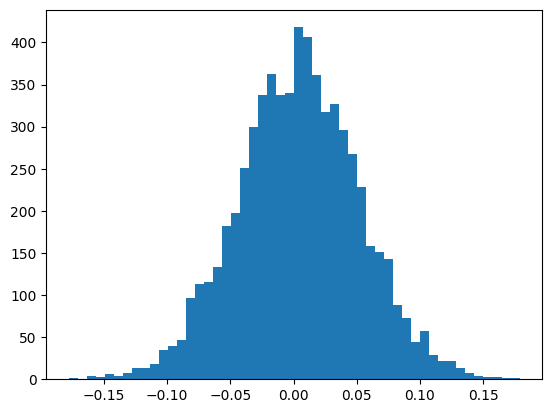

In [19]:
plt.hist(h.view(-1).tolist(),50);

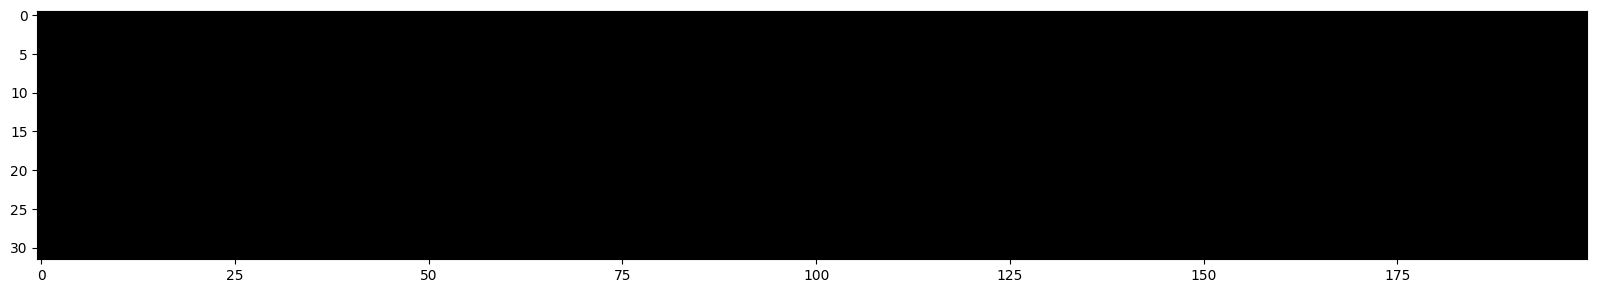

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

¡Todo funciona **correctamente** ahora!


### Valores óptimos en la inicialización

Dada la importancia de este problema, numerosas investigaciones se han enfocado en él. Una publicación destacada es [*Delving Deep into Rectifiers*](https://arxiv.org/pdf/1502.01852), que introduce la **inicialización de Kaiming**. Este trabajo propone valores de inicialización específicos para cada función de activación, garantizando una **distribución centrada y reducida** en toda la red.

Este método está implementado en [PyTorch](https://pytorch.org/docs/stable/nn.init.html), y las capas que creemos en PyTorch se inicializan **automáticamente** de esta manera.


### ¿Por qué este curso está en los bonos cuando parece muy importante?

Este problema es, efectivamente, **un desafío clave**. Sin embargo, al usar **PyTorch**, todos los parámetros ya se inicializan correctamente, por lo que **no suele ser necesario** modificarlos manualmente.

Además, se han propuesto diversas técnicas para mitigar este problema, entre las que destacan:
- **Batch Normalization (*Batch Norm*)**: Normaliza los valores antes de la activación en cada capa de la red (se abordará en el siguiente notebook).
- **Conexiones residuales (*Residual Connections*)**: Permiten propagar el gradiente a través de toda la red sin que este se vea afectado en exceso por las funciones de activación.

Aunque estas consideraciones son **fundamentales**, en la práctica no es estrictamente necesario dominarlas para entrenar una red neuronal, gracias a las optimizaciones ya integradas en frameworks como PyTorch.
